Как было сказано ранее, GAN обучается воспроизводить реальные данные. Поэтому Вам предлагается обучить генератор создавать точки, которые будут лежать на графике функции  𝑦=𝑠𝑖𝑛(𝑥)𝑥−𝑥10 . При выполненинии данного задания структура GAN остается той же, но Вам нужно:
Сгенерировать настоящие данные
Изменить архитектуру дискриминатора и генератора
Без графиков домашку не принимаю (реальные данные + результат модели, графики двух лоссов)
Дополнительно: посмотреть зависимость от количества изначальных реальных данных (график)

Изменить используемые модели генератора и дискриминатора, с помощью сверточных слоев. Идея: https://arxiv.org/abs/1511.06434 Датасет можно использовать так же MNIST.

In [2]:
import os
import numpy as np
import math
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import datasets
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
from IPython import display
from torchvision.utils import save_image, make_grid

In [20]:
import itertools
import pickle
import imageio
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.patches as mpatches
import time

import warnings
warnings.filterwarnings("ignore")

In [3]:
def func(x: np.array):
    return np.sin(x)/x - x/10

In [4]:
train_data_length = 1024

train_data = torch.zeros((train_data_length, 2))
xx = np.linspace(-10, 10, train_data_length)
train_data[:, 0] = torch.tensor(xx)
train_data[:, 1] = torch.tensor(func(xx))
train_labels = torch.ones(train_data_length)
train_set = [
    (train_data[i], train_labels[i]) for i in range(train_data_length)]

In [5]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True)

In [6]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        def block(in_feat, out_feat):
            layers = [nn.Linear(in_feat, out_feat)]
            layers.append(nn.LeakyReLU(0.2))
            return layers

        self.model = nn.Sequential(
            *block(2, 16),
            *block(16, 32),
            nn.Linear(32, 2))

    def forward(self, x):
        output = self.model(x)
        return output

In [7]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        def block(in_feat, out_feat):
            layers = [nn.Linear(in_feat, out_feat)]
            layers.append(nn.LeakyReLU(0.2))
            layers.append(nn.Dropout(0.3))
            return layers

        self.model = nn.Sequential(
            *block(2, 256),
            *block(256, 128),
            *block(128, 64),
            nn.Linear(64, 1),
            nn.Sigmoid())

    def forward(self, x):
        output = self.model(x)
        return output

In [8]:
lr = 0.001
num_epochs = 300

generator = Generator()
discriminator = Discriminator()

optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr)

loss_function = torch.nn.BCELoss()

In [9]:
for epoch in range(num_epochs):
    for n, (real_samples, _) in enumerate(train_loader):
        
        real_samples_labels = torch.ones((batch_size, 1))
        latent_space_samples = torch.randn((batch_size, 2))
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1))
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels))

       
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        optimizer_D.step()

       
        latent_space_samples = torch.randn((batch_size, 2))

       
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels)
        loss_generator.backward()
        optimizer_G.step()

       
        if (epoch + 1) % 50 == 0 and n == (batch_size - 1):
            print(f"Epoch: {epoch + 1} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch + 1} Loss G.: {loss_generator}")
            print("-"*40)

Epoch: 50 Loss D.: 0.6380603313446045
Epoch: 50 Loss G.: 0.771863579750061
----------------------------------------
Epoch: 100 Loss D.: 0.7541297674179077
Epoch: 100 Loss G.: 0.6131349802017212
----------------------------------------
Epoch: 150 Loss D.: 0.6710589528083801
Epoch: 150 Loss G.: 0.7191439867019653
----------------------------------------
Epoch: 200 Loss D.: 0.6578448414802551
Epoch: 200 Loss G.: 0.791772723197937
----------------------------------------
Epoch: 250 Loss D.: 0.6040792465209961
Epoch: 250 Loss G.: 1.0219639539718628
----------------------------------------
Epoch: 300 Loss D.: 0.7115166783332825
Epoch: 300 Loss G.: 0.6771968603134155
----------------------------------------


In [10]:
latent_space_samples = torch.randn(1024, 2)
generated_samples = generator(latent_space_samples)

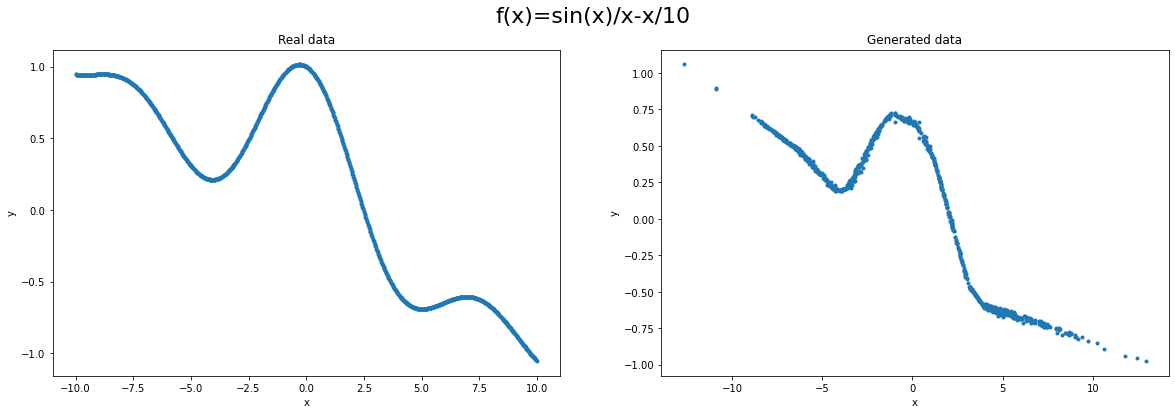

In [11]:
generated_samples = generated_samples.detach()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
ax1.plot(xx, func(xx), ".")
ax1.set_title("Real data")
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax2.plot(generated_samples[:, 0], generated_samples[:, 1], ".")
ax2.set_title("Generated data")
ax2.set_xlabel("x")
ax2.set_ylabel("y")
fig.suptitle("f(x)=sin(x)/x-x/10", fontsize=22)
plt.show()

Изменить используемые модели генератора и дискриминатора, с помощью сверточных слоев. Идея: https://arxiv.org/abs/1511.06434 Датасет можно использовать так же MNIST.

In [31]:
n_epochs = 50
batch_size = 64
lr = 0.0002

b1 = 0.5
b2 = 0.999

latent_dim = 100

n_classes = 10
img_size = 32
channels = 1

sample_interval = 25

img_shape = (channels, img_size, img_size)

In [23]:
real_data = torch.utils.data.DataLoader(
    datasets.MNIST(
        "../../data/mnist",
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.Resize(img_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
        ),
    ),
    batch_size=batch_size,
    shuffle=True,
)

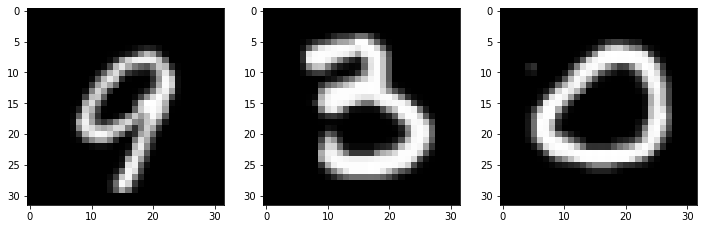

In [24]:
dataiter = iter(real_data)
images, labels = dataiter.next()
images = images.numpy()

img = np.squeeze(images[0])
img1 = np.squeeze(images[1])
img2 = np.squeeze(images[2])

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (12,4))
ax1.imshow(img, cmap='gray')
ax2.imshow(img1, cmap='gray')
ax3.imshow(img2, cmap='gray')

In [25]:
def sample_image(static_sample, save_img = False):
    npimg = make_grid(static_sample.data[:25]).cpu().numpy()
    fig, ax = plt.subplots(figsize=(7, 7))
    ax.imshow(np.transpose(npimg, (1,2,0)), interpolation="nearest")
    if save_img:
        save_image(gen_imgs.data[:25], "images/%d.png" % batches_done, nrow=5, normalize=True)

In [26]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.init_size = img_size // 4
        self.l1 = nn.Sequential(nn.Linear(latent_dim, 128 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 1, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, z):
        out = self.l1(z)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img

In [27]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, bn=True):
            block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1), nn.LeakyReLU(0.2, inplace=True), nn.Dropout2d(0.25)]
            if bn:
                block.append(nn.BatchNorm2d(out_filters, 0.8))
            return block

        self.model = nn.Sequential(
            *discriminator_block(1, 16, bn=False),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
        )

        # The height and width of downsampled image
        ds_size = img_size // 2 ** 4
        self.adv_layer = nn.Sequential(nn.Linear(128 * ds_size ** 2, 1), nn.Sigmoid())

    def forward(self, img):
        out = self.model(img)
        out = out.view(out.shape[0], -1)
        validity = self.adv_layer(out)

        return validity

In [28]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)


optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

adversarial_loss = torch.nn.BCELoss()
d_loss_history = []
g_loss_history = []

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 49/50] [Batch 937/938] [D loss: 1.024808] [G loss: 2.653812]


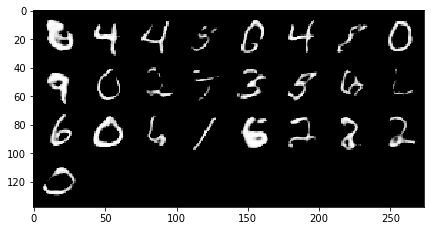

<Figure size 432x288 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

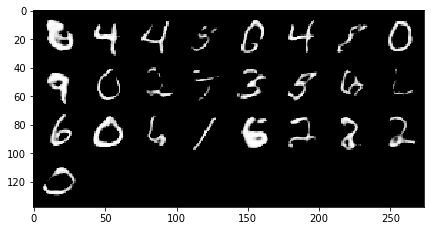

In [32]:
red_patch = mpatches.Patch(color='red', label='D loss')
green_patch = mpatches.Patch(color='green', label='G loss')



for epoch in range(n_epochs):
    for i, (imgs, labels) in enumerate(real_data):

        batch_size = imgs.shape[0]

        valid = Variable(torch.FloatTensor(batch_size, 1).fill_(1.0), requires_grad=False).to(device)
        fake = Variable(torch.FloatTensor(batch_size, 1).fill_(0.0), requires_grad=False).to(device)

        real_imgs = Variable(imgs.type(torch.FloatTensor)).to(device)




        optimizer_G.zero_grad()
    
        
        z = Variable(torch.FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim)))).to(device)

        gen_imgs = generator(z)

        validity = discriminator(gen_imgs)
        g_loss = adversarial_loss(validity, valid)
        
        g_loss.backward()
        optimizer_G.step()
        
        optimizer_D.zero_grad()

        real_pred = discriminator(real_imgs)
        d_real_loss = adversarial_loss(real_pred, valid)

        fake_pred = discriminator(gen_imgs.detach())
        d_fake_loss = adversarial_loss(fake_pred, fake)

        d_loss = (d_real_loss + d_fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()
        
        batches_done = epoch * len(real_data) + i
        
    plt.clf()
            
    display.clear_output(wait=False)
    sample_image(gen_imgs)
    print("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"% (epoch, n_epochs, i, len(real_data), d_loss.item(), g_loss.item()) ) 
        
    display.display(plt.gcf())